In [1]:
%matplotlib inline

import numpy as np
from numpy import linalg as nla
import scipy as sp
from scipy import linalg as sla
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import SHFunctions as shf
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
np.set_printoptions(linewidth = 200)

In [2]:
def NewtonSchulz(p, A, Q, X0 = np.NAN, maxiter = 100, tol = np.NAN):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
        X0 = np.eye(A.shape[0])
    
    if (p <= 0) or (not isinstance(p, int)): # p가 positive integer가 아닐 때 예외처리
        raise ValueError('p가 양의 정수가 아닙니다.')
        
    if A.shape[0] != A.shape[1]: # A가 square matrices의 모음이 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    if Q.shape[0] != Q.shape[1]: # Q가 square matrices의 모음이 아닐 때 예외처리
        raise ValueError('Q가 정방행렬이 아닙니다.')
        
    if (Q.shape[0] != A.shape[0]) or (A.shape[1] != Q.shape[1]): # A와 Q가 같은 크기 아닐 때 예외처리
        raise ValueError('A, Q가 같은 크기가 아닙니다.')
        
    m = A.shape[1] # m 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    errs = [] # err 리스트 초기화
    S = np.zeros((A.shape[0],A.shape[1]))
    
    iter = 0
    err = 1e10 # error 초기화
    
    # Newton Iteration 시작
    t = time() # 시간체크
    while (err > tol) and (iter < maxiter):
        X0 = (1/p)*((p-1)*X0 + (Q - A.conj().transpose() @ X0 @ A)@nla.inv(nla.matrix_power(X0,p-1))) # Newton Sequence 적용
        err = nla.norm(nla.matrix_power(X0, p) - (Q - (A.conj()).transpose() @ X0 @ A), 'fro') # err 계산

        Xs.append(X0) # X_i 저장
        errs.append(err) # err 저장
        
        iter += 1
    
    calcultime = time() - t
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'errs':errs, 'time':calcultime, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX}

In [3]:
p = 2
A = np.random.rand(10,10) * 1e-2
Q = np.eye(10)

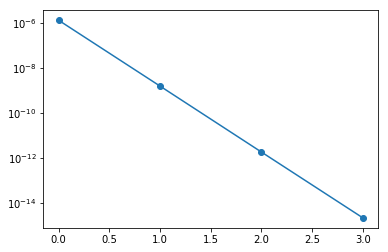

In [4]:
Ss = NewtonSchulz(p, A, Q)
ax = plt.subplot(111)
ax.semilogy(Ss['errs'],'-o')

In [5]:
S = Ss['sol']
print(S)
print(Ss['time'])
print(nla.matrix_power(S, p) - (Q - A.conj().transpose() @ S @ A))

[[ 9.99827078e-01 -1.89883040e-04 -1.86646244e-04 -1.72920881e-04 -1.11670666e-04 -1.08532694e-04 -1.15612356e-04 -9.80748542e-05 -9.06275554e-05 -1.26715437e-04]
 [-1.89883040e-04  9.99747296e-01 -2.03774776e-04 -1.80831599e-04 -1.32429437e-04 -1.42947227e-04 -1.25848859e-04 -1.13703958e-04 -1.21827549e-04 -1.29886708e-04]
 [-1.86646244e-04 -2.03774776e-04  9.99762070e-01 -1.85509461e-04 -1.27036337e-04 -1.37781619e-04 -1.23268573e-04 -9.82898620e-05 -1.08626067e-04 -1.28551857e-04]
 [-1.72920881e-04 -1.80831599e-04 -1.85509461e-04  9.99790871e-01 -1.08075244e-04 -9.87908856e-05 -9.63420059e-05 -1.06634517e-04 -9.95316880e-05 -1.41671782e-04]
 [-1.11670666e-04 -1.32429437e-04 -1.27036337e-04 -1.08075244e-04  9.99877860e-01 -1.26071249e-04 -9.23372910e-05 -7.37001464e-05 -9.36448576e-05 -1.00222507e-04]
 [-1.08532694e-04 -1.42947227e-04 -1.37781619e-04 -9.87908856e-05 -1.26071249e-04  9.99849377e-01 -9.62711193e-05 -5.59705610e-05 -1.15603808e-04 -1.01258962e-04]
 [-1.15612356e-04 -1.2

In [6]:
Ss['csXmX']

[-0.9646327452671877, -0.9815924993126421, -0.9924063285814854]